<a href="https://colab.research.google.com/github/vanshikaramadurgam/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 212 kB 34.9 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[5],labels[5]

('ive been feeling a little burdened lately wasnt sure why that was',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
#anything not in the most frequently used 10000 words are tokenized as UNK
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[5]])

[[73, 48, 8, 7, 56, 521, 319, 328, 158, 161, 9, 20]]

In [ ]:
tweets[5]

'ive been feeling a little burdened lately wasnt sure why that was'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

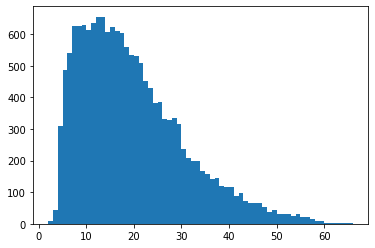

In [ ]:
#done because the model we create needs a fixed input shape
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
#any tweet over 50 words is truncated and any tweet belowe 50 words is padded with just 0's
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded= pad_sequences(sequences, truncating='post',padding='post',maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq= get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes= set(labels)
print(classes)

{'joy', 'love', 'surprise', 'anger', 'sadness', 'fear'}


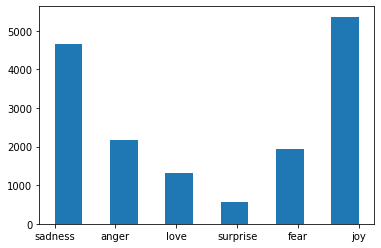

In [ ]:
plt.hist(labels,bins=11)
plt.show() #checking how many examples are there for each emotion in the dataset

In [ ]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 3, 'fear': 5, 'joy': 0, 'love': 1, 'sadness': 4, 'surprise': 2}

In [ ]:
index_to_class

{0: 'joy', 1: 'love', 2: 'surprise', 3: 'anger', 4: 'sadness', 5: 'fear'}

In [ ]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])

4


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [ ]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 41s 63ms/step - loss: 1.3396 - accuracy: 0.4753 - val_loss: 0.9582 - val_accuracy: 0.6490
Epoch 2/20
500/500 [==============================] - 30s 59ms/step - loss: 0.7623 - accuracy: 0.7093 - val_loss: 0.6633 - val_accuracy: 0.7670
Epoch 3/20
500/500 [==============================] - 30s 59ms/step - loss: 0.4854 - accuracy: 0.8386 - val_loss: 0.5489 - val_accuracy: 0.8270
Epoch 4/20
500/500 [==============================] - 30s 60ms/step - loss: 0.3675 - accuracy: 0.8834 - val_loss: 0.5303 - val_accuracy: 0.8290
Epoch 5/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2967 - accuracy: 0.9052 - val_loss: 0.4537 - val_accuracy: 0.8535
Epoch 6/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2379 - accuracy: 0.9233 - val_loss: 0.4179 - val_accuracy: 0.8735
Epoch 7/20
500/500 [==============================] - 30s 60ms/step - loss: 0.1904 - accuracy: 0.9376 - val_loss: 0.4252 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

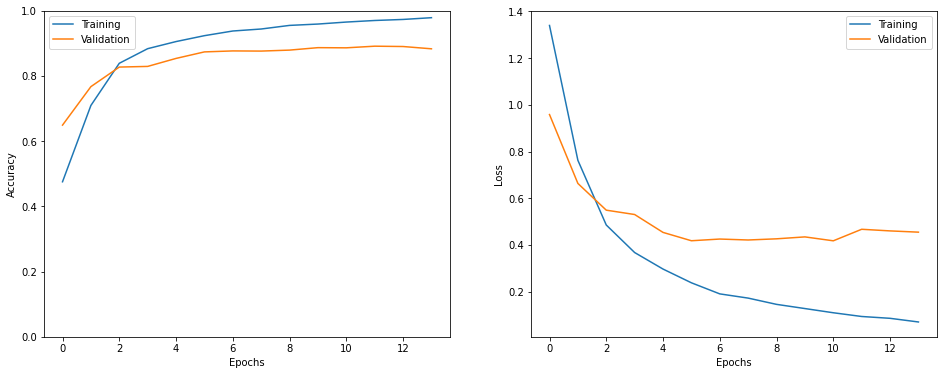

In [ ]:
show_history(h)

In [ ]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 21ms/step - loss: 0.4928 - accuracy: 0.8710


In [79]:
i=random.randint(0,len(test_labels)-1)
print('Sentence:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:',pred_class)

Sentence: i feel for this divine landmass and all the respect i bear in my heart for the greatness residing on it
Emotion: joy
Predicted Emotion: joy


In [ ]:
preds=model.predict(test_seq)
classes_p=np.argmax(preds,axis=1)

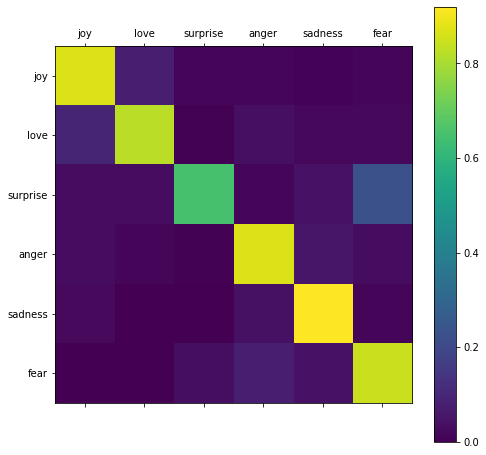

In [ ]:
show_confusion_matrix(test_labels,classes_p,list(classes))